In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB


import seaborn as sns
import ast 
%load_ext autoreload 
%autoreload 2

In [2]:
# Import evaluation functions
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [3]:
#read in the data
moviesData = pd.read_csv("./tmdb-5000-movie-dataset/tmdb_5000_movies_new.csv")

In [4]:
labels = moviesData['vote_average']

In [5]:
#data filtering and cleansing
# list for columns with strings
stringsList = [] 
# print(moviesData.head())

for colname, colvalue in moviesData.iteritems():
    if type(colvalue[1]) == str:
        stringsList.append(colname)
        
numsList = moviesData.columns.difference(stringsList)

# numsList

#get columns that don't contain strings

moviesDataNums = moviesData[numsList]

# moviesDataNums = moviesDataNums.drop('id', axis=1)
print(moviesDataNums.head())

      budget      id  popularity     revenue  runtime  vote_average  \
0  237000000   19995  150.437577  2787965087    162.0           7.2   
1  300000000     285  139.082615   961000000    169.0           6.9   
2  245000000  206647  107.376788   880674609    148.0           6.3   
3  250000000   49026  112.312950  1084939099    165.0           7.6   
4  260000000   49529   43.926995   284139100    132.0           6.1   

   vote_count  
0       11800  
1        4500  
2        4466  
3        9106  
4        2124  


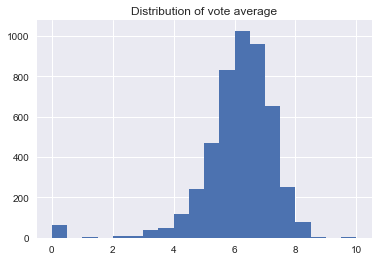

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(labels, bins=20)
plt.title("Distribution of vote average")
plt.show()

In [7]:
#add a new dimension for director popularity and cast popularity
# iterate over dataframe to get popularity values for an id. for two directors only keep the first one
movies_credits_Data = pd.read_csv("./tmdb-5000-movie-dataset/tmdb_5000_credits.csv")
movie_to_director = {} #key:movieID, value:directorID

crew = movies_credits_Data['crew']
movieIDS = movies_credits_Data['movie_id']

for index, row in crew.iteritems():
    row = ast.literal_eval(row)
    for credit_dict in row:
        if credit_dict['job'] == 'Director':
            movie_id = movieIDS[index]
            if movie_id not in movie_to_director.keys(): #only first director included
                movie_to_director[movie_id] = credit_dict['id']

movie_to_cast = {}
cast = movies_credits_Data['cast']
for index, row in cast.iteritems():
    row = ast.literal_eval(row)
    actors = []
    movie_id = movieIDS[index]
    for cast_dict in row:
        actors.append(cast_dict["id"])
    movie_to_cast[movie_id] = actors
        


In [8]:
#load director_id to popularity dict that was pickled
with open('director_info_dict_pkl','rb') as f:
    director_dict_loaded = pickle.load(f)

print(director_dict_loaded[2710])

{'name': 'James Cameron', 'popularity': 4.973699}


In [9]:
movie_series = moviesDataNums['id']
director_id_array = []
director_popularity_array = []
for movie_id in movie_series:
    if movie_id in movie_to_director.keys():
        director_id_array.append(movie_to_director[movie_id])
        director_popularity_array.append(director_dict_loaded[movie_to_director[movie_id]]['popularity'])
    else:
        director_id_array.append(0)
        director_popularity_array.append(0)

In [10]:
moviesDataNums['director_popularity'] = director_popularity_array

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
#load cast popularity
with open('cast_info_dict_pkl','rb') as f:
    cast_popularity_dict = pickle.load(f)

In [12]:
#add new feature for average actor popularity
#open credits file. Pick first three members of cast and take average
cast_popularity_array = []
for movie_id in movie_series:
    actors = movie_to_cast[movie_id][:3]
    popularity = 0.0
    for actor in actors:
        popularity += cast_popularity_dict[actor]['popularity']
    popularity = popularity/3
    cast_popularity_array.append(popularity)

In [13]:
moviesDataNums['cast_popularity'] = cast_popularity_array

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
# remove rows that have incorrect budget. Assuming anything below 100 budget to be incorrect

4803
3742


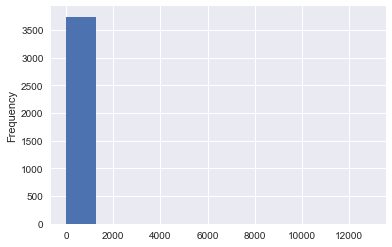

In [15]:
#add new feature (would act as label) for profit percent
print(len(moviesDataNums))
moviesDataNums = moviesDataNums[moviesDataNums.budget > 100]
print(len(moviesDataNums))

moviesDataNums['profit'] = ((moviesDataNums['revenue'] - moviesDataNums['budget'])/moviesDataNums['budget'])
moviesDataNums['profit'].plot(kind='hist')

In [16]:
#create new label
#0: Poor, 1:some loss, 2: some profit, 3: huge profit
profit_score = []
# for profit in moviesDataNums['profit']:
#     if profit <= -0.5:
#         profit_score.append(0)
#     elif profit >-0.5 and profit<=1.0:
#         profit_score.append(1)
#     elif profit > 1.0 and profit<2.0:
#         profit_score.append(2)
#     elif profit > 1.0 and profit<2.0:
#         profit_score.append(3)
#     elif profit >=2.0 and profit<3.0:
#         profit_score.append(4)
#     elif profit >=3.0 and profit<4.0:
#         profit_score.append(5)
#     elif profit >=4.0 and profit<5.0:
#         profit_score.append(6)
#     elif profit >=5.0:   
#         profit_score.append(7)   

for profit in moviesDataNums['profit']:
    if profit <= -0.5:
        profit_score.append(0)
    elif profit >-0.5 and profit<=1.0:
        profit_score.append(1)
    elif profit > 1.0 and profit<2.0:
        profit_score.append(2)
    elif profit >=2.0 and profit<3.0:
        profit_score.append(3)
    elif profit >=3.0:   
        profit_score.append(4)            

In [17]:
moviesDataNums['profit_score'] = profit_score

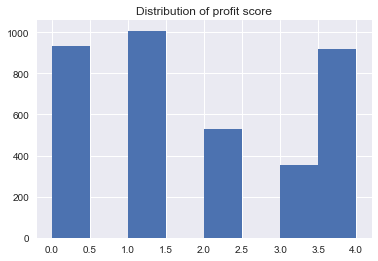

In [18]:
labels = moviesDataNums['profit_score']
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(labels, bins = 8)
plt.title("Distribution of profit score")
plt.show()

In [19]:
with_zero = 0
for i, item in enumerate(director_id_array):
    if item == 0:
        with_zero += 1
print(with_zero)
#       this shows we have rows with no director info, so delete these rows
print(len(moviesDataNums))

30
3742


In [20]:
print(len(moviesDataNums))
moviesDataNums = moviesDataNums[moviesDataNums.director_popularity != 0]
print("After dropping rows with no director popularity info")
print(len(moviesDataNums))

3742
After dropping rows with no director popularity info
3659


In [21]:
#remove NaN values
moviesDataNums = moviesDataNums.fillna(value = 0, axis=1)
print(len(moviesDataNums))
print(moviesDataNums.head())

3659
      budget      id  popularity     revenue  runtime  vote_average  \
0  237000000   19995  150.437577  2787965087    162.0           7.2   
1  300000000     285  139.082615   961000000    169.0           6.9   
2  245000000  206647  107.376788   880674609    148.0           6.3   
3  250000000   49026  112.312950  1084939099    165.0           7.6   
4  260000000   49529   43.926995   284139100    132.0           6.1   

   vote_count  director_popularity  cast_popularity     profit  profit_score  
0       11800             4.973699         6.977320  10.763566             4  
1        4500             3.107182         9.584808   2.203333             3  
2        4466             2.667000         7.862515   2.594590             3  
3        9106             3.160919         6.206075   3.339756             4  
4        2124             1.588633         2.638264   0.092843             1  


In [22]:
#standardize data using sklearn StandardScaler
# Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.movieDataStdValues = StandardScaler().fit_transform(movieDataValues)
print(moviesDataNums.shape)

(3659, 11)


In [23]:
movieDataValues = moviesDataNums.values

from sklearn.preprocessing import StandardScaler, Normalizer
movieDataStdValues = StandardScaler().fit_transform(movieDataValues[:, [0,1,2,3,4,5,6,7,8]])
# movieDataStdValues = StandardScaler().fit_transform(movieDataValues)

y_normal =  Normalizer().fit_transform(movieDataValues[:,10])
#normalize profit_score values from 0 to 1


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


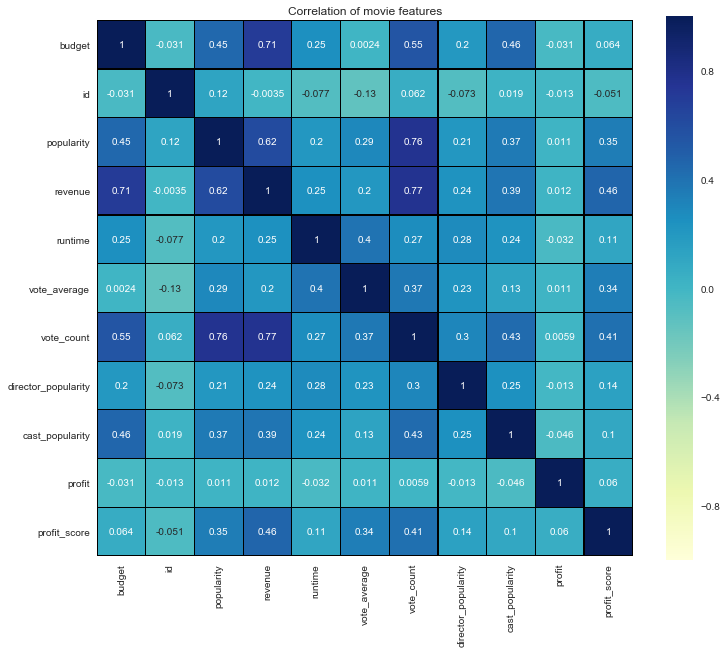

In [24]:
#heatmap showing correlation of features

f, ax = plt.subplots(figsize = (12,10))
plt.title("Correlation of movie features")
sns.heatmap(moviesDataNums.astype(float).corr(), linewidths=0.25, vmax=1.0,
           square = True, cmap="YlGnBu", linecolor = "black", annot = True)

In [25]:
# Initialize a few classifiers for comparison
clfs = [DecisionTreeClassifier(), SVC(), BernoulliNB()]

In [46]:
#ignore id i.e. index 1

#use standard values
movieDataValues = movieDataStdValues

x = movieDataValues[:, [0,3,4,7,8]] #only considering budget, runtime, director_popularity and cast_popularity
# y = movieDataValues[:, 5:6] #predicting imdb score
# y1 = moviesDataNums.values[:, 10] #predicting profit_score

# y1 = movieDataValues[:, 10] #predicting profit_score

y = y_normal*1000 #predicting profit_score that is normalized

y = np.transpose(y)

#change y's shape
y = y.ravel()
int_y = y.tolist()
y1 = list(map(round,int_y))
y1 = list(map(int,int_y))
y1 = np.array(y1)
print(y1.shape)

27.6891211691
20.7668408768
20.7668408768
27.6891211691
6.92228029228
20.7668408768
13.8445605846
27.6891211691
20.7668408768
20.7668408768
6.92228029228
13.8445605846
27.6891211691
0.0
13.8445605846
6.92228029228
27.6891211691
13.8445605846
13.8445605846
20.7668408768
20.7668408768
6.92228029228
20.7668408768
13.8445605846
13.8445605846
27.6891211691
27.6891211691
6.92228029228
27.6891211691
27.6891211691
20.7668408768
27.6891211691
27.6891211691
13.8445605846
20.7668408768
27.6891211691
27.6891211691
13.8445605846
20.7668408768
13.8445605846
13.8445605846
6.92228029228
27.6891211691
6.92228029228
27.6891211691
13.8445605846
13.8445605846
13.8445605846
6.92228029228
20.7668408768
13.8445605846
13.8445605846
27.6891211691
27.6891211691
6.92228029228
13.8445605846
6.92228029228
13.8445605846
6.92228029228
20.7668408768
6.92228029228
6.92228029228
6.92228029228
27.6891211691
20.7668408768
27.6891211691
27.6891211691
13.8445605846
27.6891211691
6.92228029228
6.92228029228
13.8445605846
27

27.6891211691
6.92228029228
6.92228029228
6.92228029228
6.92228029228
6.92228029228
13.8445605846
6.92228029228
6.92228029228
13.8445605846
6.92228029228
6.92228029228
27.6891211691
6.92228029228
6.92228029228
6.92228029228
6.92228029228
6.92228029228
0.0
0.0
6.92228029228
6.92228029228
0.0
6.92228029228
6.92228029228
6.92228029228
13.8445605846
6.92228029228
0.0
6.92228029228
0.0
6.92228029228
6.92228029228
6.92228029228
0.0
6.92228029228
6.92228029228
0.0
0.0
6.92228029228
27.6891211691
0.0
0.0
0.0
6.92228029228
0.0
0.0
0.0
0.0
6.92228029228
0.0
6.92228029228
0.0
0.0
0.0
6.92228029228
0.0
6.92228029228
0.0
13.8445605846
0.0
0.0
0.0
0.0
13.8445605846
0.0
27.6891211691
27.6891211691
27.6891211691
0.0
13.8445605846
13.8445605846
27.6891211691
20.7668408768
6.92228029228
6.92228029228
6.92228029228
6.92228029228
0.0
13.8445605846
0.0
6.92228029228
6.92228029228
6.92228029228
6.92228029228
0.0
6.92228029228
20.7668408768
0.0
0.0
6.92228029228
27.6891211691
27.6891211691
27.6891211691
27.6

In [27]:
#todo: print time taken by each classifier
X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=.2)
k = 20
for clf in clfs:
#     clf.fit(X_train, y_train)
#     print(type(clf).__name__, clf.score(X_test, y_test))
    k_cross_scores = cross_val_score(clf, x, y1, cv=k)
    print ((type(clf).__name__),k_cross_scores, "avg:",sum(k_cross_scores)/k )

DecisionTreeClassifier [ 0.6344086   0.74731183  0.79891304  0.82608696  0.79347826  0.85869565
  0.88043478  0.875       0.86413043  0.87431694  0.89071038  0.87978142
  0.81868132  0.84615385  0.86740331  0.82872928  0.82872928  0.79005525
  0.71270718  0.60773481] avg: 0.811173129228
SVC [ 0.65053763  0.85483871  0.86413043  0.85326087  0.85326087  0.88586957
  0.95652174  0.9076087   0.88043478  0.84699454  0.83060109  0.80327869
  0.78021978  0.72527473  0.65745856  0.60773481  0.51381215  0.35911602
  0.35911602  0.29281768] avg: 0.724144368583
BernoulliNB [ 0.1827957   0.25268817  0.29347826  0.41304348  0.54891304  0.66304348
  0.75543478  0.67934783  0.56521739  0.45901639  0.44808743  0.3989071
  0.3956044   0.34615385  0.35359116  0.35359116  0.32044199  0.29281768
  0.34254144  0.25966851] avg: 0.416219161813


In [39]:
#finally pickle the decision tree classifier (performs best for profit score)
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)
pickle.dump(d_tree, open('d_tree_pickle.sav', 'wb'))

In [47]:
loaded_model = pickle.load(open('d_tree_pickle.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.904371584699
